# Customer Segmentation with Instacart
<img src="http://cdn.multichannelmerchant.com/wp-content/uploads/2018/01/instacart.jpg" alt="instacart" title="instacart" />

## Introduction:
Instacart is a service that allows customers to order their groceries to be delivered to home from stores like Whole Foods, Target, and Costco. The company has provided data on the order and product details. In order to make sense of Instacart's customer groups, this notebook will be detailing methods that should provide more insight into the different buying behaviors of Instacart's customers.

# Notebook Contents
> ## 1. Part I: Merging Relevant Data
> ## 2. Part II: Dimensionality Reduction with PCA
> ## 3. Part III: Optimizing K-Means Clustering with Silhoutte Score
> ## 4. Part IV: Cluster Analysis
> ## 5. Part V: Discussion of Cluster Differences

## Part I: Merging Relevant Data

In [35]:
# import libraries
import numpy as np 
import pandas as pd 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, chi2, f_classif
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

orders = pd.read_csv('data/orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [2]:
prior = pd.read_csv('data/order_products__prior.csv')
print prior.shape
prior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [3]:
train = pd.read_csv('data/order_products__train.csv')
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [4]:
#make priors into a smaller set for local computing power
prior = prior[0:300000]
order_prior = pd.merge(prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
221645,23391,13198,1,1,7,prior,17,0,10,28.0
221646,23391,42803,2,1,7,prior,17,0,10,28.0
221647,23391,8277,3,1,7,prior,17,0,10,28.0
221648,23391,37602,4,1,7,prior,17,0,10,28.0
221649,23391,40852,5,1,7,prior,17,0,10,28.0


In [5]:
products = pd.read_csv('data/products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
aisles = pd.read_csv('data/aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [7]:
_mt = pd.merge(prior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs


In [8]:
print 'most popular items'
mt['product_name'].value_counts().sort_values(ascending=False)[0:10]

most popular items


Banana                    4432
Bag of Organic Bananas    3563
Organic Strawberries      2370
Organic Baby Spinach      2242
Organic Hass Avocado      1985
Organic Avocado           1626
Large Lemon               1380
Strawberries              1343
Organic Raspberries       1293
Limes                     1270
Name: product_name, dtype: int64

In [9]:
print 'number of unique products'
len(mt['product_name'].unique())

number of unique products


24836

In [10]:
print 'number of unique aisles'
len(mt['aisle'].unique())

number of unique aisles


134

In [11]:
print 'most popular aisles'
mt['aisle'].value_counts()[0:10]

most popular aisles


fresh fruits                     33755
fresh vegetables                 31004
packaged vegetables fruits       16319
yogurt                           13477
packaged cheese                   9133
milk                              8254
water seltzer sparkling water     7634
chips pretzels                    6581
soy lactosefree                   5965
bread                             5457
Name: aisle, dtype: int64

In [12]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,4
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
cust_prod.sum(axis=0).sort_values(ascending=False)[:10]

aisle
fresh fruits                     33755
fresh vegetables                 31004
packaged vegetables fruits       16319
yogurt                           13477
packaged cheese                   9133
milk                              8254
water seltzer sparkling water     7634
chips pretzels                    6581
soy lactosefree                   5965
bread                             5457
dtype: int64

In [14]:
cust_prod.shape

(25831, 134)

## Part II: Dimensionality Reduction with PCA
To speed up the clustering process, the customer product dataset will undergo dimensionality reduction with PCA. The reduced dataset will then be inspected for a possible pair of variables that will be suitable for clustering.

In [15]:
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [16]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5
0,-0.286251,1.005868,-1.030291,-0.898947,-0.587772,-0.998434
1,-1.972748,-0.487659,-0.120542,0.213079,0.046003,-0.181917
2,-1.168974,1.284089,3.228123,0.594040,-0.648830,-1.091948
3,-1.433967,1.250081,3.261984,1.237728,-0.353448,-0.346641
4,-2.070709,-0.422148,-0.101553,0.278103,0.006268,-0.097676


<Figure size 1080x720 with 0 Axes>

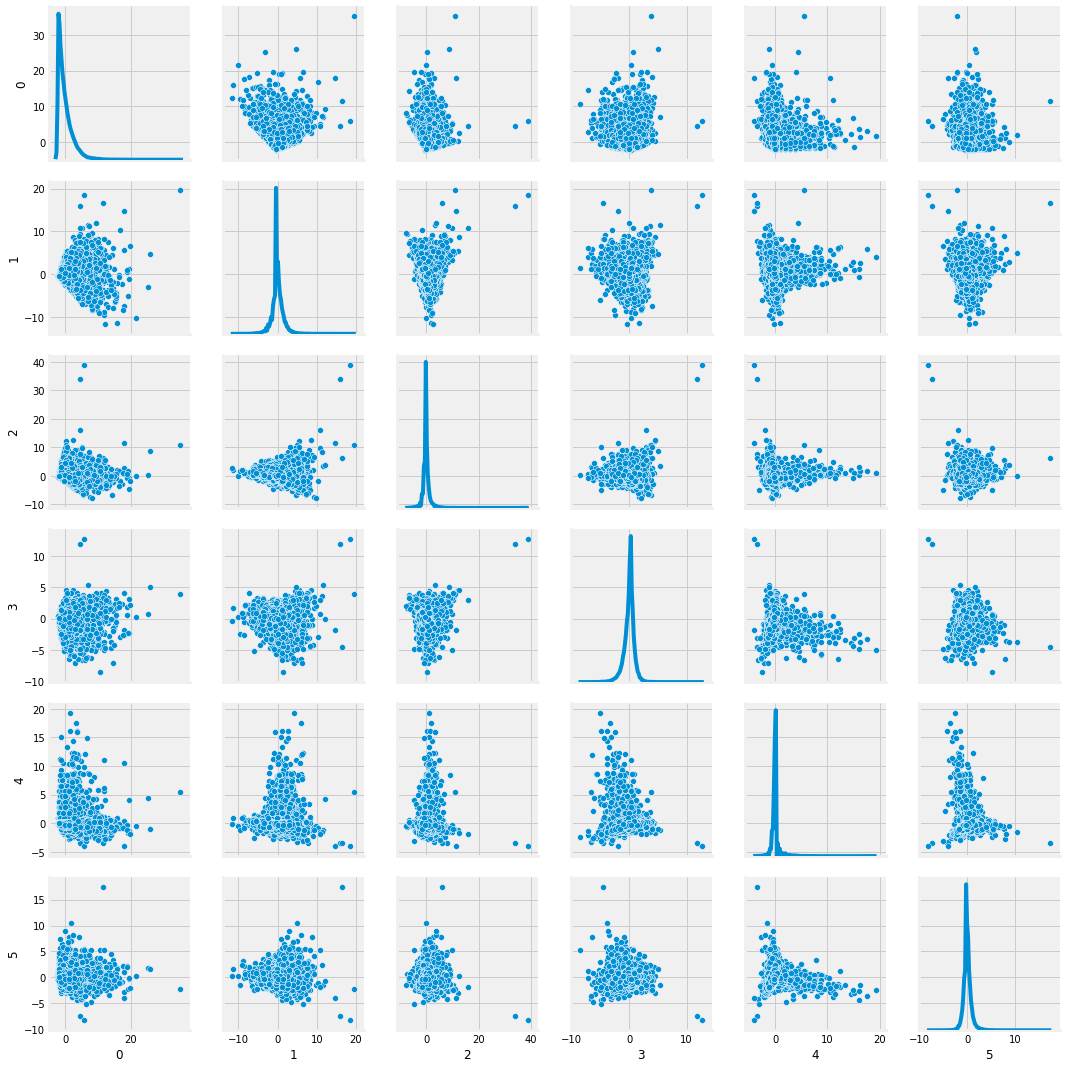

In [17]:
plt.figure(figsize=(15,10))
sns.pairplot(data=ps,diag_kind='kde')
plt.show()

In [18]:
# I found this unsupervised feature selection in the following link
# https://stats.stackexchange.com/questions/108743/methods-in-r-or-python-to-perform-feature-selection-in-unsupervised-learning
class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features

    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]

        sc = StandardScaler()
        X = sc.fit_transform(X)

        pca = PCA(n_components=self.q).fit(X)
        A_q = pca.components_.T

        kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_

        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))

        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]

In [19]:
# the above function applied
pfa = PFA(n_features=2)
pfa.fit(ps.values)

# To get the transformed matrix
X2 = pfa.features_

# To get the column indices of the kept features
column_indices = pfa.indices_
print column_indices
print X2.shape
print X2

[2, 5]
(25831, 2)
[[-0.8922771  -1.23453233]
 [-0.10439427 -0.22493421]
 [ 2.79569597 -1.35016021]
 ...
 [-0.07473898  0.17517004]
 [ 0.4463829  -0.47312401]
 [-0.36309709 -0.32477964]]


#### Commentary
The above function recommends that the 4, 0 pair should be used for clustering. A visual inspection of the above pairplot suggests that the 4,1 pair may be a good contender too.

(25831, 2)
          0         1
0 -0.892277 -1.234532
1 -0.104394 -0.224934
2  2.795696 -1.350160
3  2.825021 -0.428611
4 -0.087950 -0.120773


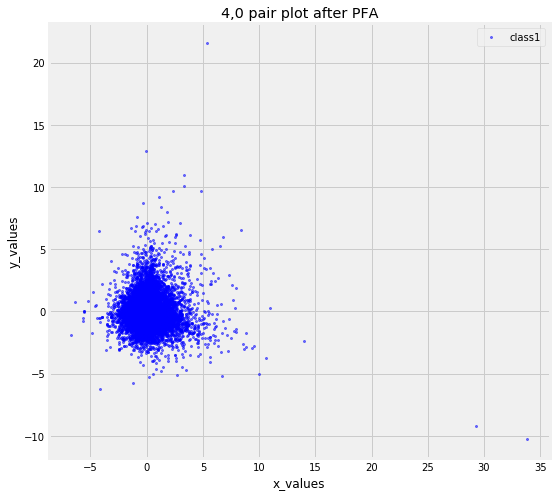

In [20]:
tocluster = pd.DataFrame(pd.DataFrame(X2))

print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[0], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')
plt.title('4,0 pair plot after PFA')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

(25831, 2)
          4         0
0 -0.587772 -0.286251
1  0.046003 -1.972748
2 -0.648830 -1.168974
3 -0.353448 -1.433967
4  0.006268 -2.070709


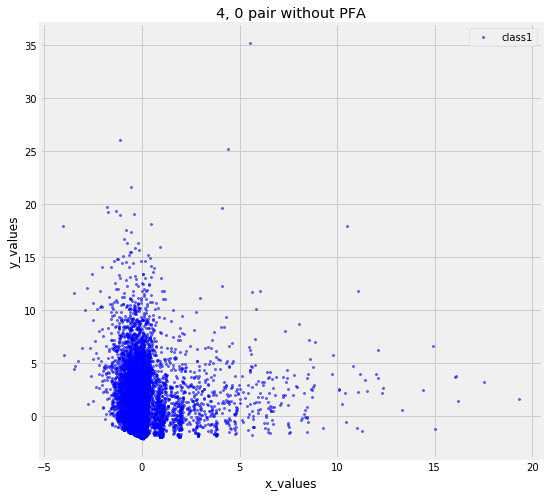

In [21]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[4,0]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[0], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.title('4, 0 pair without PFA')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

(25831, 2)
          4         1
0 -0.587772  1.005868
1  0.046003 -0.487659
2 -0.648830  1.284089
3 -0.353448  1.250081
4  0.006268 -0.422148


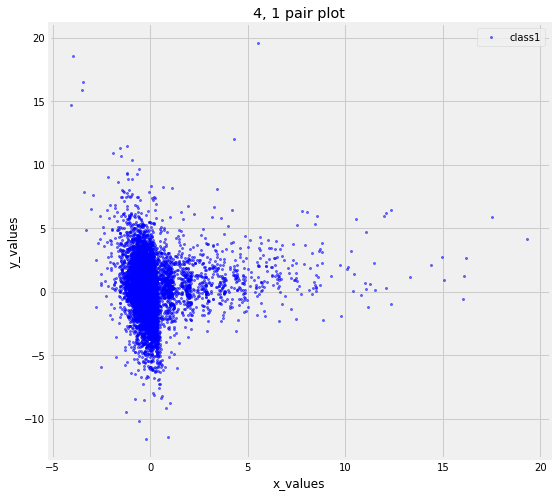

In [22]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[4,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')
plt.title('4, 1 pair plot')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

## Part III: Optimizing K-Means Clustering with Silhoutte Score
The 4,0 and 4,1 pairs will be compared in terms of which give more defined clusters, or in more technical terms, which will give a higher silhoutte score.

In [23]:
def clustering_silhoutte(i,j):
    tocluster = pd.DataFrame(ps[[i,j]])
    
    clusters_list=[]
    sil_list=[]
    
    for s in [2,3,4,5,6,7]:
        clusterer = KMeans(n_clusters=s,random_state=42).fit(tocluster)
        #centers = clusterer.cluster_centers_
        c_preds = clusterer.predict(tocluster)
        silhouette_avg = silhouette_score(tocluster,c_preds,metric='euclidean')
        #print("For n_clusters =", s, "The average silhouette_score is:", silhouette_avg)
        clusters_list.append(s)
        sil_list.append(silhouette_avg)
    return zip(clusters_list,sil_list)

four_0_c_score=clustering_silhoutte(4,0)
four_1_c_score=clustering_silhoutte(4,1)

In [24]:
print "4/0 pair of pca silh score"
print four_0_c_score
print "\n4/1 pair of pca silh score"
print four_1_c_score

4/0 pair of pca silh score
[(2, 0.6374569446587065), (3, 0.5707780176229406), (4, 0.5336450976613816), (5, 0.5482901698863013), (6, 0.5179222556075751), (7, 0.4993530684733639)]

4/1 pair of pca silh score
[(2, 0.4889605792184343), (3, 0.514863459400838), (4, 0.5287422890584395), (5, 0.4910057273584305), (6, 0.4657495758483229), (7, 0.44508783972020716)]


In [25]:
def clustering_silhoutte():
    
    clusters_list=[]
    sil_list=[]
    
    for s in [2,3,4,5,6,7]:
        clusterer = KMeans(n_clusters=s,random_state=42).fit(ps.values)
        #centers = clusterer.cluster_centers_
        c_preds = clusterer.predict(ps.values)
        silhouette_avg = silhouette_score(ps.values,c_preds,metric='euclidean')
        #print("For n_clusters =", s, "The average silhouette_score is:", silhouette_avg)
        clusters_list.append(s)
        sil_list.append(silhouette_avg)
    return zip(clusters_list,sil_list)
# for all pca data
clustering_silhoutte()

[(2, 0.47195095468605563),
 (3, 0.3815720556073504),
 (4, 0.3731647700322644),
 (5, 0.38134743506257435),
 (6, 0.3117587044733873),
 (7, 0.32828459278124605)]

#### Commentary
The best silhoutte score is achieved in the 4/0 pair with 2 clusters and it diminishes from there. The 4/1 pair peaks at 4 clusters. I would like to investigate the variations between multiple groups. So I will be choosing the  4/0 pair with 5 clusters to assign customer segmentation labels.

In [26]:
clusterer = KMeans(n_clusters=5,random_state=42).fit(ps[[4,0]])
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(ps[[4,0]])
print(centers)
print(c_preds[0:100])

[[-0.01081321 -1.49603094]
 [-0.20587779  9.09242639]
 [-0.16673848  3.48968101]
 [-0.1274194   0.56323954]
 [ 5.90525718  1.64112993]]
[3 0 0 0 0 0 0 0 0 2 3 0 3 0 0 4 0 0 2 3 0 0 0 3 0 1 1 0 0 2 3 0 3 3 2 0 0
 0 0 2 3 0 3 0 0 0 0 0 0 0 3 0 3 0 0 0 3 3 0 0 2 0 0 0 0 3 0 0 2 2 0 0 0 0
 3 3 2 0 0 3 0 0 3 3 0 0 2 0 0 3 0 3 0 3 0 0 0 2 0 0]


In [27]:
clusters_df=ps.copy()
clusters_df['cluster']=c_preds
clusters_df['cluster'].value_counts()

0    14128
3     7587
2     3272
1      543
4      301
Name: cluster, dtype: int64

## Part IV: Cluster Analysis
The following section will detail the differences among the 5 clusters created.

/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


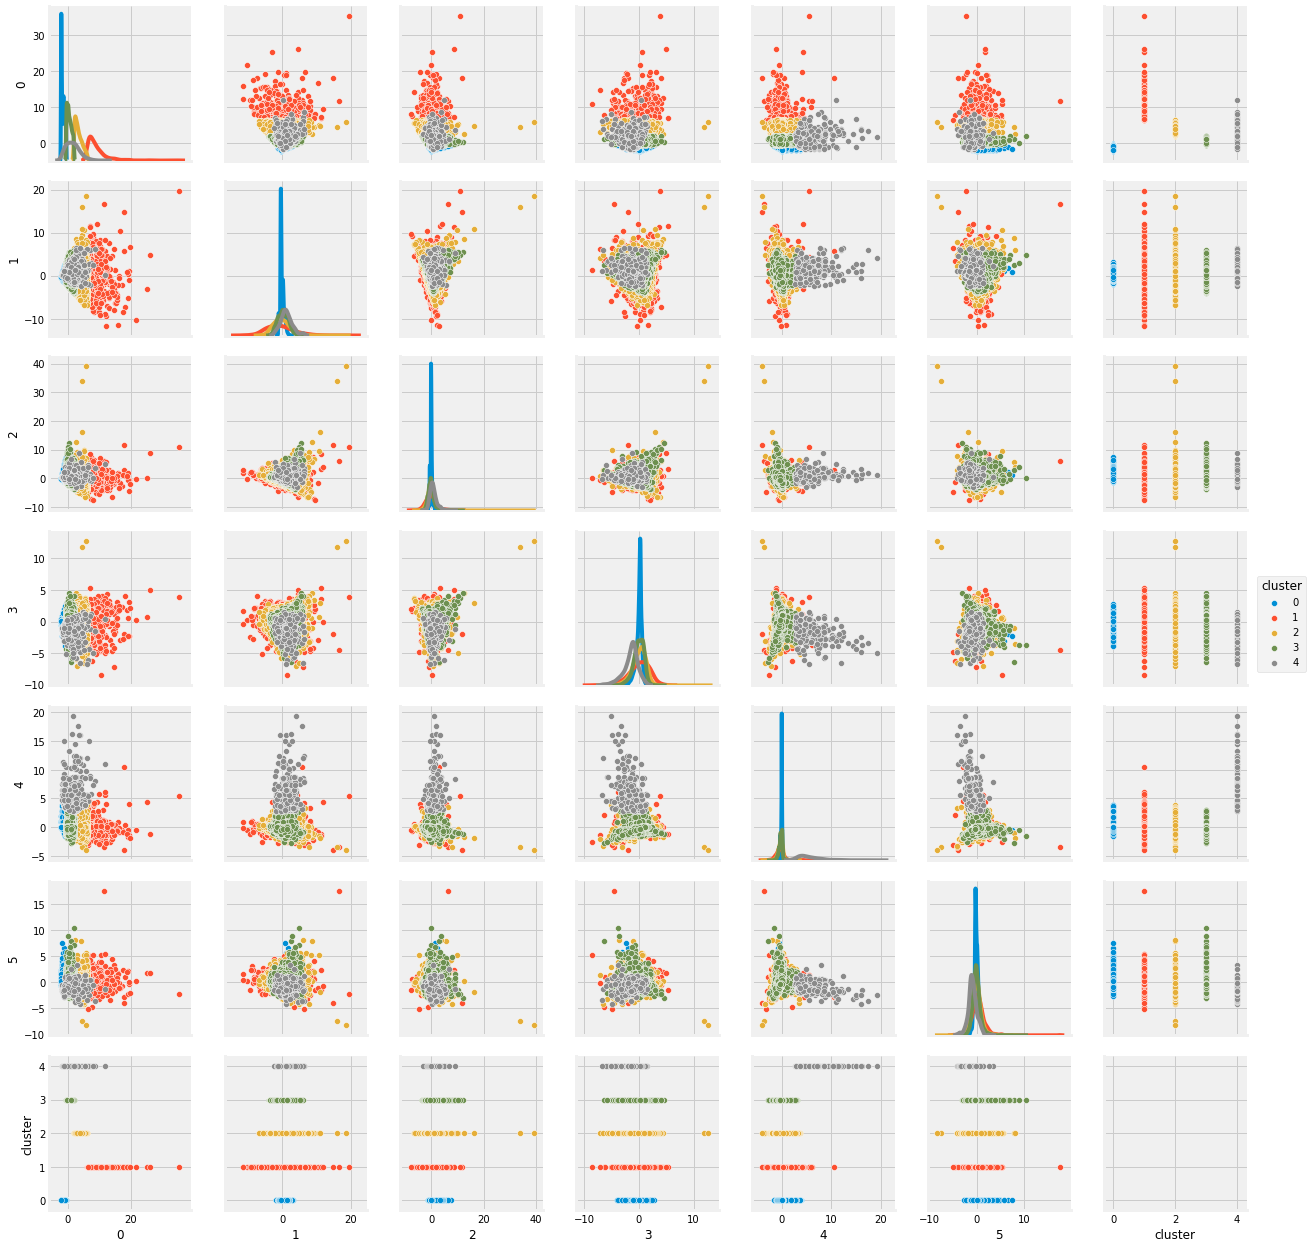

In [28]:
sns.pairplot(data=clusters_df,hue='cluster',diag_kind='kde')
plt.show()

In [29]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
13,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,4,0
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,4,0
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Cluster Analysis Using Feature Selection
### all features

In [44]:
# scale
clust_fs=clust_prod.copy().iloc[:,:-1]
for f in list(clust_fs):
    clust_fs[f]=MinMaxScaler().fit_transform(clust_fs[f].values.reshape(-1,1)).flatten()

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [82]:
y=clust_prod.iloc[:,-1]
X=clust_fs
selector = SelectPercentile(f_classif, percentile=50)
selector.fit(X, y)
import_features=pd.DataFrame(zip(list(clust_fs),selector.scores_))
import_features.columns=['feature','score']
top10_tf=selector.fit_transform(X,y)
import_features=import_features[import_features['feature'].isin(list(clust_fs.iloc[:,selector.get_support(indices=True)]))].sort_values(by=['score'],ascending=False)
print 'using all clusters during feature selection'
import_features.head()

using all clusters during feature selection


,feature,score
53,fresh vegetables,13474.068089
4,baby food formula,12334.258235
50,fresh fruits,7223.289957
98,packaged vegetables fruits,2470.461556
51,fresh herbs,784.307547


### One vs All

In [81]:
dum=pd.get_dummies(clust_prod['cluster'])
dum.columns=['c'+str(x) for x in range(5)]                   
onedf=pd.concat([clust_fs,dum],axis=1)

print 'shape of dataframe and value counts of clsuters'
print onedf.shape
print onedf[dum.columns].sum()
print '\n'

def one_vs_all_feat_select():
    for i in dum.columns:
        X=clust_fs
        y=onedf[i]
        selector = SelectPercentile(f_classif, percentile=50)
        selector.fit(X, y)
        import_features=pd.DataFrame(zip(list(clust_fs),selector.scores_))
        import_features.columns=['feature','score']
        top10_tf=selector.fit_transform(X,y)
        import_features=import_features[import_features['feature'].isin(list(clust_fs.iloc[:,selector.get_support(indices=True)]))].sort_values(by=['score'],ascending=False)
        print i + ' feature_importance'
        print import_features.head()
        print '\n'

one_vs_all_feat_select()

shape of dataframe and value counts of clsuters
(25831, 139)
c0    14128
c1      543
c2     3272
c3     7587
c4      301
dtype: int64


c0 feature_importance
                        feature         score
50                 fresh fruits  13903.321205
53             fresh vegetables  13283.007150
98   packaged vegetables fruits   5931.461167
93              packaged cheese   1639.124488
133                      yogurt   1593.563589


c1 feature_importance
                       feature         score
53            fresh vegetables  10345.871574
50                fresh fruits   5655.521848
98  packaged vegetables fruits   2662.947022
51                 fresh herbs   1145.709106
93             packaged cheese    725.724062


c2 feature_importance
                       feature        score
53            fresh vegetables  9600.312899
50                fresh fruits  6114.187761
98  packaged vegetables fruits  2811.129473
51                 fresh herbs  1254.120666
93             packaged chee

# xgboost feature importance

In [84]:
y=clust_prod.iloc[:,-1]
X=clust_fs
xgtrain = xgb.DMatrix(X, label=y)
clf = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model=clf
model.fit(X,y)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

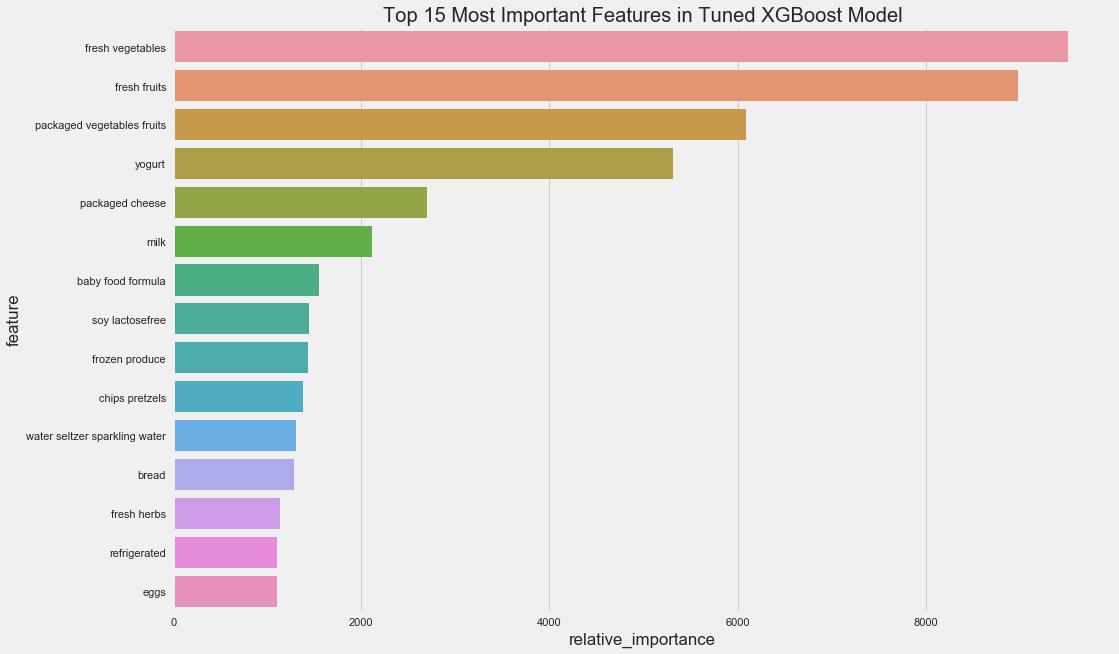

In [92]:
top_15_features=pd.DataFrame.from_dict(clf.get_booster().get_score(importance_type='weight'),orient='index').sort_values([0],ascending=False).head(15).reset_index()
top_15_features.columns=['feature','relative_importance']
plt.figure(figsize=(15,10))
plt.title("Top 15 Most Important Features in Tuned XGBoost Model")
sns.barplot(y='feature',x='relative_importance',data=top_15_features,orient='h')

# Examining Difference via EDA/Viz

(25831, 135)


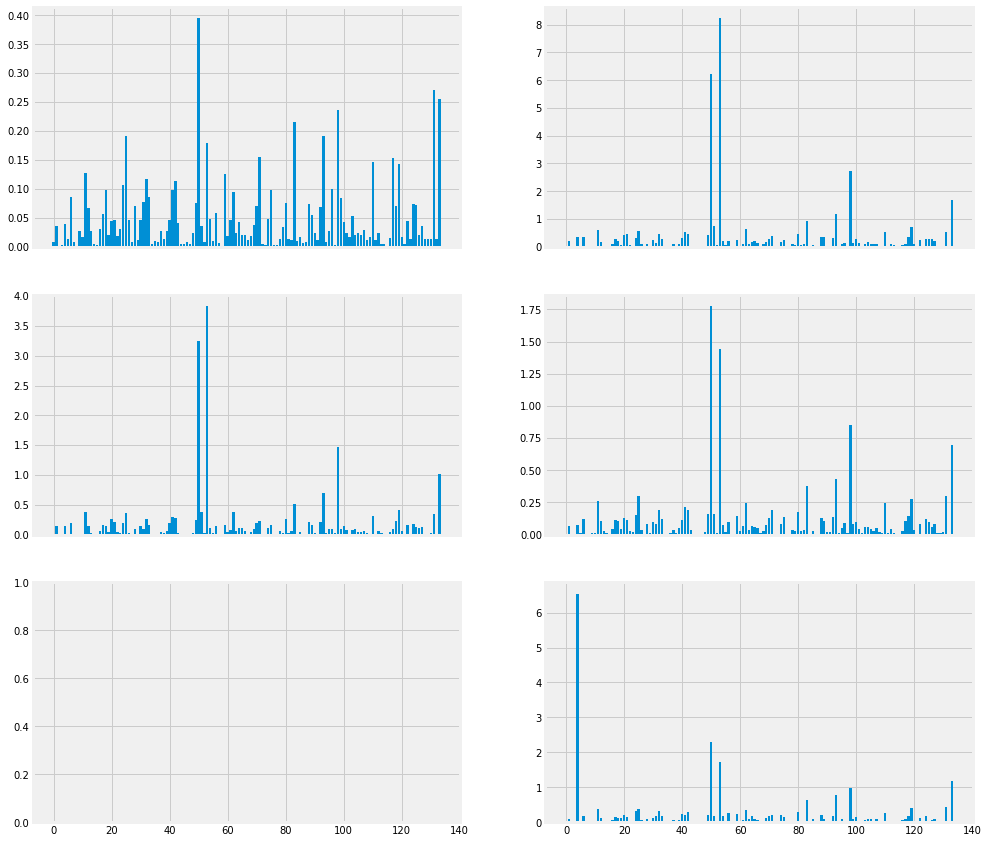

In [30]:
print (clust_prod.shape)
f,arr = plt.subplots(3,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)

c4 = clust_prod[clust_prod['cluster']==4].drop('cluster',axis=1).mean()
arr[2,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c4)
plt.show()

For Each Cluster: Mean Items Ordered Per Aisle Per Customer


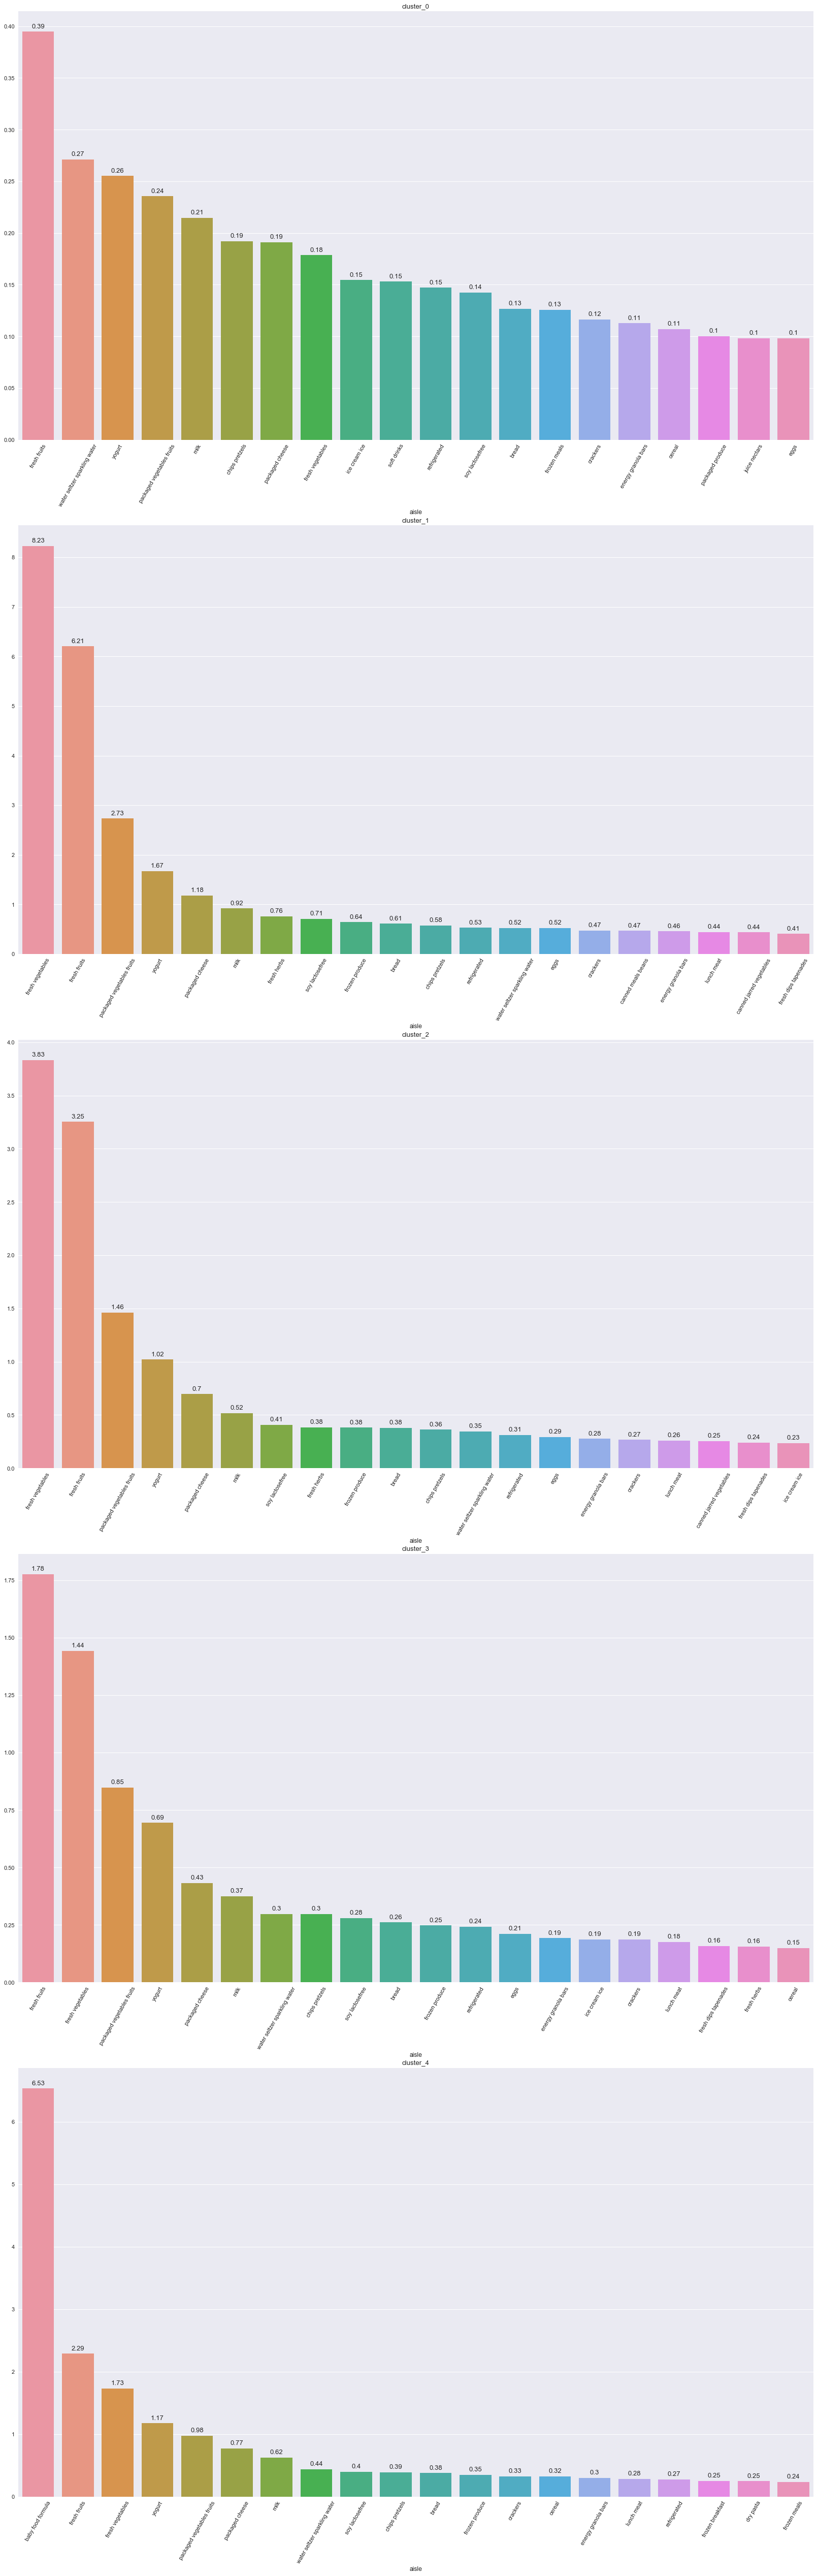

In [31]:
cluster_names=['cluster_'+str(i) for i in range(0,5)]
cluster_list=[c0,c1,c2,c3,c4]

plt.figure(figsize=(25,90))
i=1
print 'For Each Cluster: Mean Items Ordered Per Aisle Per Customer'
sns.set(font_scale=1.1)
for c in cluster_list:
    
    plt.subplot(5,1,i)
    plt.title(cluster_names[i-1])
    plt.xticks(rotation=60)
    ax=sns.barplot(x=c.sort_values(ascending=False)[0:20].index,y=c.sort_values(ascending=False)[0:20])
    for p in ax.patches: 
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    i+=1
    #print str(c)
    #print c.sort_values(ascending=False)[0:10]
    #print '\n'

In [32]:
cluster_perc_df=clust_prod.groupby('cluster')[list(clust_prod)[:-1]].sum()
total_by_cluster=cluster_perc_df.sum(axis=1)
cluster_perc_df=cluster_perc_df.div(cluster_perc_df.sum(axis=1), axis=0)
cluster_perc_df['total']=total_by_cluster
cluster_perc_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,total
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.001289,0.005346,0.000298,0.000319,0.005942,0.001959,0.012832,0.001203,0.000277,0.003983,...,0.010809,0.003088,0.005516,0.002055,0.002002,0.001970,0.040817,0.002002,0.038400,93907
1,0.000046,0.005212,0.000411,0.000137,0.008366,0.000411,0.009143,0.000274,0.000091,0.000046,...,0.006949,0.006766,0.005166,0.000411,0.000320,0.001051,0.013029,0.000000,0.041510,21874
2,0.000192,0.006231,0.000178,0.000206,0.006038,0.000631,0.008399,0.000467,0.000165,0.000096,...,0.005311,0.004735,0.005901,0.000563,0.000618,0.000919,0.015494,0.000069,0.045838,72866
3,0.000405,0.005066,0.000222,0.000212,0.005558,0.000830,0.008743,0.000434,0.000135,0.000589,...,0.007238,0.004053,0.006099,0.000772,0.000647,0.001486,0.021771,0.000502,0.050856,103626
4,0.000129,0.003624,0.001165,0.000647,0.254562,0.000259,0.006730,0.000259,0.000000,0.000388,...,0.001294,0.002718,0.004141,0.000776,0.000388,0.001165,0.016954,0.000129,0.045684,7727


Percent Distribution of Items Ordered Per Cluster


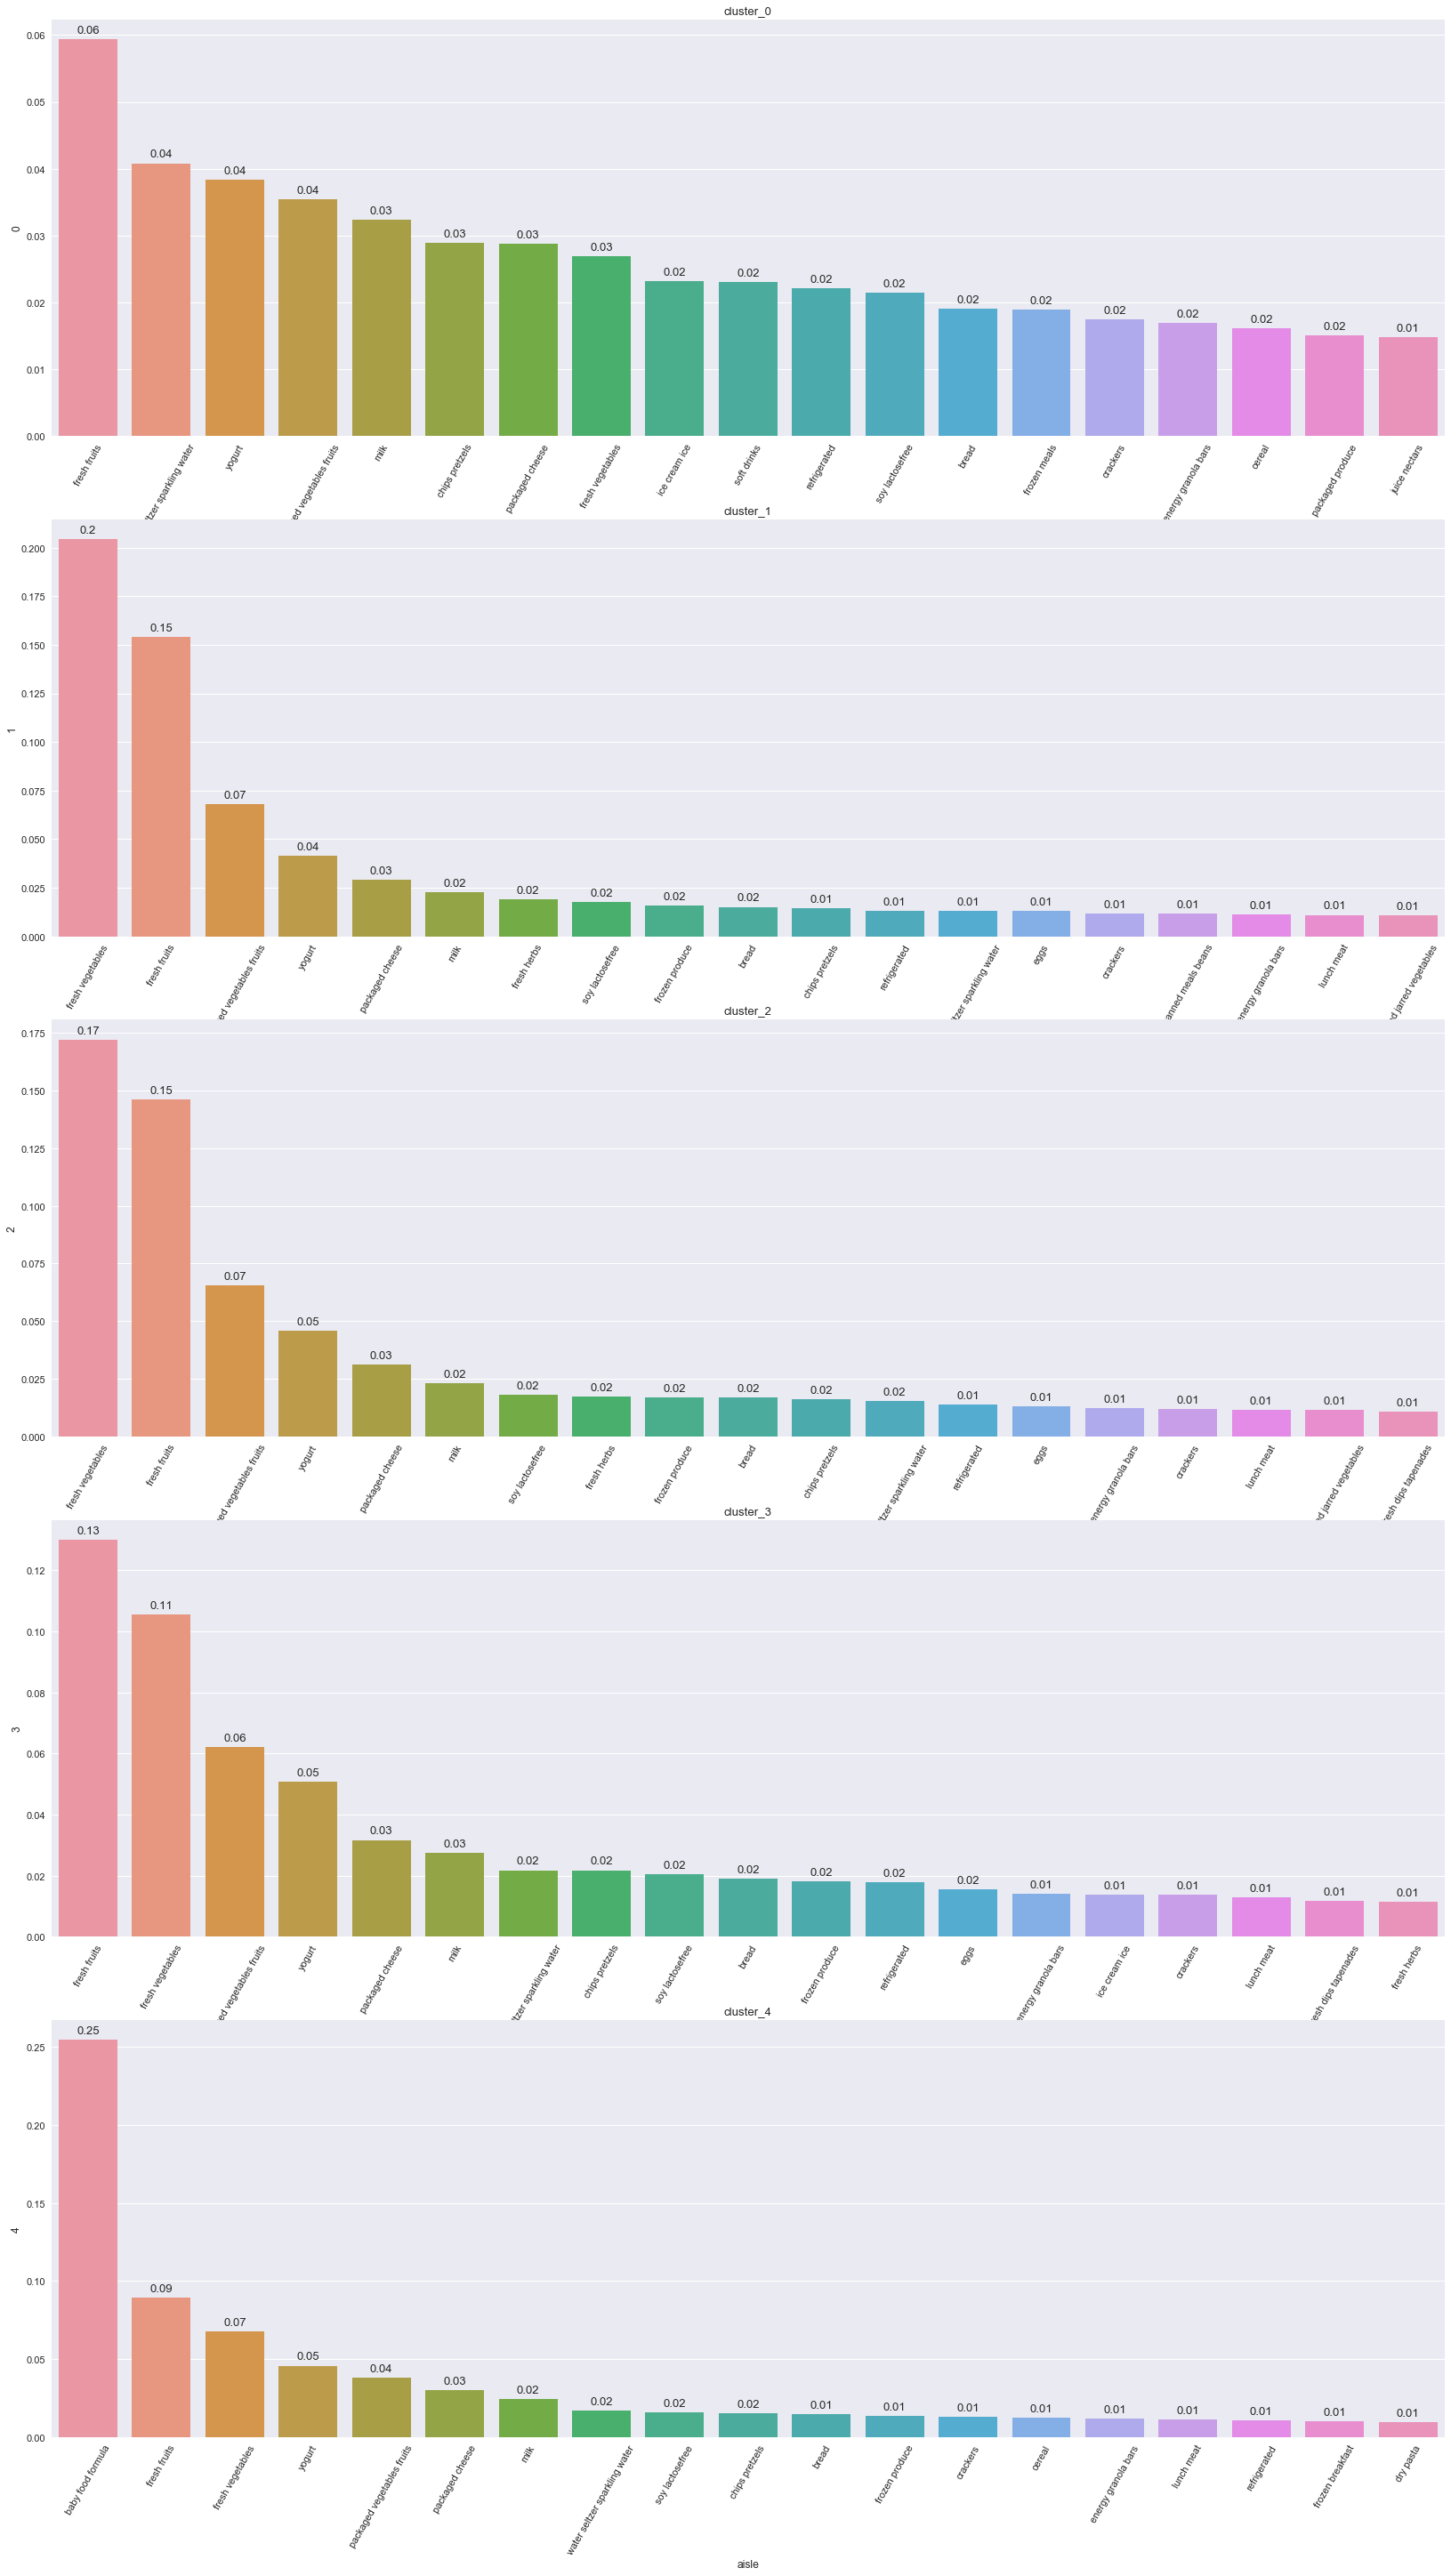

In [33]:
plt.figure(figsize=(25,50))
print "Percent Distribution of Items Ordered Per Cluster"
for i in range(0,5):
    plt.subplot(5,1,i+1)
    plt.title('cluster_'+str(i))
    plt.xticks(rotation=60)
    ax=sns.barplot(x=cluster_perc_df.iloc[i].sort_values(ascending=False)[1:20].index,y=cluster_perc_df.iloc[i].sort_values(ascending=False)[1:20])
    for p in ax.patches: 
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
#cluster_perc_df.iloc[0].sort_values(ascending=False)[1:15]

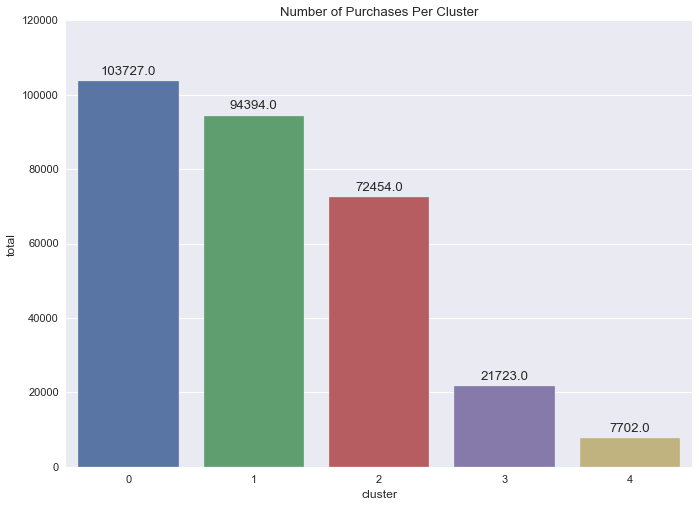

In [125]:
plt.figure(figsize=(10,8))
plt.title('Number of Purchases Per Cluster')
ax=sns.barplot(x=cluster_perc_df['total'].index,y=cluster_perc_df['total'])
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [135]:
cluster_0_top_20_items=cluster_perc_df.iloc[0].sort_values(ascending=False)[1:20].index
cluster_1_top_20_items=cluster_perc_df.iloc[1].sort_values(ascending=False)[1:20].index
cluster_2_top_20_items=cluster_perc_df.iloc[2].sort_values(ascending=False)[1:20].index
cluster_3_top_20_items=cluster_perc_df.iloc[3].sort_values(ascending=False)[1:20].index
cluster_4_top_20_items=cluster_perc_df.iloc[4].sort_values(ascending=False)[1:20].index

print 'aisles unique to cluster 0 and not cluster 1'
print list(set(cluster_0_top_20_items).difference(cluster_1_top_20_items))
print 'aisles unique to cluster 0 and not cluster 2'
print list(set(cluster_0_top_20_items).difference(cluster_2_top_20_items))

aisles unique to cluster 0 and not cluster 1
['fresh herbs', 'fresh dips tapenades', 'frozen produce', 'lunch meat']
aisles unique to cluster 0 and not cluster 2
['ice cream ice']


In [144]:
import itertools

cluster_combo=list(itertools.permutations(range(0,5), 2))
cluster_20_list=[cluster_0_top_20_items,cluster_1_top_20_items,cluster_2_top_20_items,\
                 cluster_3_top_20_items,cluster_4_top_20_items]

c0_list=[]
c1_list=[]
c2_list=[]
c3_list=[]
c4_list=[]

unique_c_lists=[c0_list,c1_list,c2_list,c3_list,c4_list]

# capture most unique aisles per cluster
for i in cluster_combo:
    unique_c_lists[i[0]].append(list(set(cluster_20_list[i[0]]).difference(cluster_20_list[i[1]])))
    print 'aisles unique to cluster_{0} and not cluster_{1}'.format(str(i[0]),str(i[1]))
    print list(set(cluster_20_list[i[0]]).difference(cluster_20_list[i[1]]))

aisles unique to cluster_0 and not cluster_1
['fresh herbs', 'fresh dips tapenades', 'frozen produce', 'lunch meat']
aisles unique to cluster_0 and not cluster_2
['ice cream ice']
aisles unique to cluster_0 and not cluster_3
['ice cream ice', 'fresh dips tapenades']
aisles unique to cluster_0 and not cluster_4
['fresh herbs', 'eggs', 'fresh dips tapenades', 'ice cream ice']
aisles unique to cluster_1 and not cluster_0
['frozen meals', 'packaged produce', 'cereal', 'soft drinks']
aisles unique to cluster_1 and not cluster_2
['frozen meals', 'packaged produce', 'cereal', 'soft drinks', 'ice cream ice']
aisles unique to cluster_1 and not cluster_3
['frozen meals', 'packaged produce', 'cereal', 'soft drinks', 'ice cream ice']
aisles unique to cluster_1 and not cluster_4
['frozen meals', 'packaged produce', 'eggs', 'soft drinks', 'ice cream ice']
aisles unique to cluster_2 and not cluster_0
['canned jarred vegetables']
aisles unique to cluster_2 and not cluster_1
['fresh herbs', 'fresh dips

sum of unique aisles between clusters per cluster


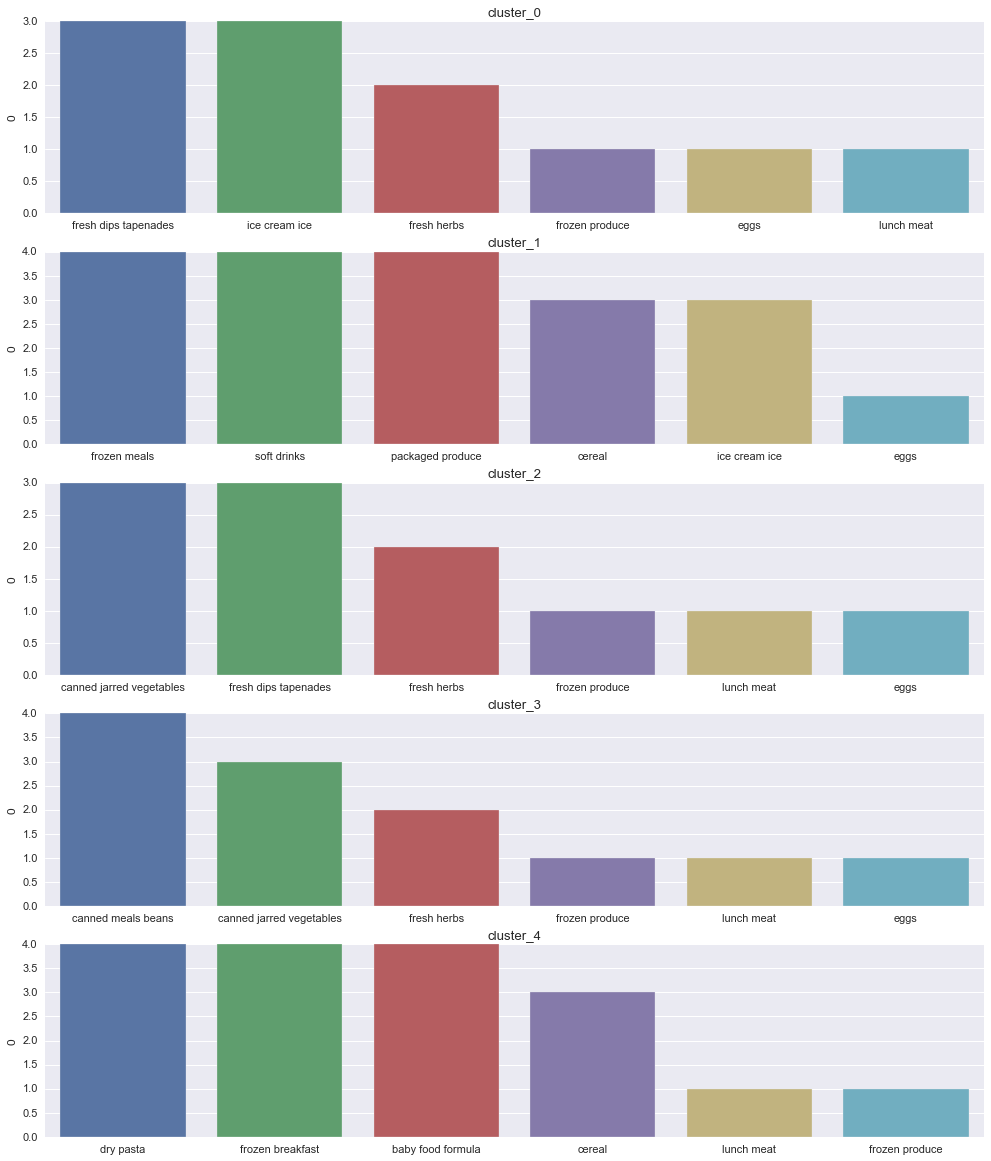

In [189]:
plt.figure(figsize=(15,20))
print 'sum of unique aisles between clusters per cluster'
for i in unique_c_lists:
    plt.subplot(5,1,unique_c_lists.index(i)+1)
    plt.title('cluster_'+str(unique_c_lists.index(i)))
    sns.barplot(x=pd.DataFrame([item for sublist in i for item in sublist])[0].value_counts().index,y=pd.DataFrame([item for sublist in i for item in sublist])[0].value_counts())
    

sum of unique aisles between clusters per cluster: sum of orders for each aisle


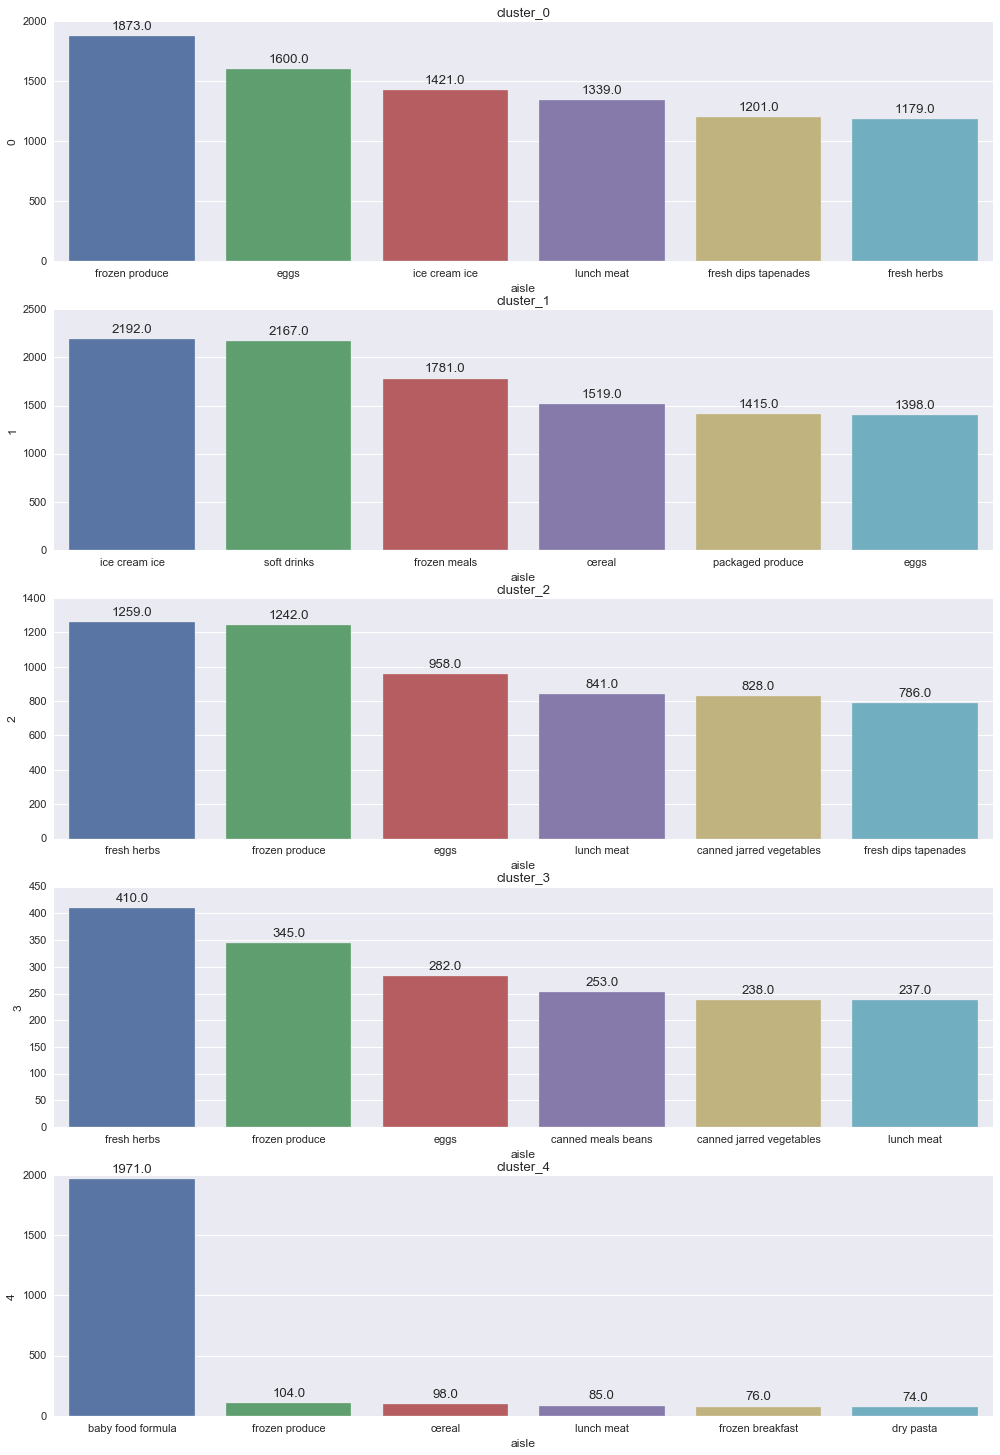

In [187]:
sum_cluster=clust_prod.groupby('cluster')[list(clust_prod)[:-1]].sum()
print 'sum of unique aisles between clusters per cluster: sum of orders for each aisle'
plt.figure(figsize=(15,25))
for i in range(0,5):
    plt.subplot(5,1,i+1)
    plt.title('cluster_'+str(i))
    x=sum_cluster[list(set([item for sublist in unique_c_lists[i] for item in sublist]))].iloc[i].sort_values(ascending=False).index
    y=sum_cluster[list(set([item for sublist in unique_c_lists[i] for item in sublist]))].iloc[i].sort_values(ascending=False)
    ax=sns.barplot(x=x,y=y)
    for p in ax.patches: 
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

## Part V: Discussion of Cluster Differences

Now for some commentary, many of the clusters do have many of the same aisles in common, which isn't a surprise seeing as most of Instacarts's users are very health-conscious evidenced by fruits and vegetables being the most purchased item categories in total. However by introducing clustering, it is possible to see some nuances in instacart's customerbase, specifically in the variations of the top 20 categories purchased among clusters. My findings are as follows:

1. Cluster 0: These customers are specially consumers of dips and ice cream.
2. Cluster 1: These customers lean into slightly unhealthy lifestyles being grouped with consuming frozen meals, soda and packaged produced.
3. Cluster 2: Consumers of canned vegetables and dips & most similar to Cluster 0
4. Cluster 3: Consumers of bean canned meals and canned veggies also similar to cluster 0 and cluster 2.
5. Cluster 4: Consumers that have been grouped together because of purchasing baby food.

Clusters 3 and 4 are noticeably smaller than Clusters 0, 1, and 2. With this in mind, it is important to not undervalue the sales of dips, ice cream, and canned goods among customers, which even though they are not the highest selling item categories overall, they represent important niche picks for high valued customer groups.